In [1]:
import os
import string
import numpy as np
import random
import arcpy
from sklearn import svm

arcpy.CheckOutExtension("ImageAnalyst")

'CheckedOut'


## Species Distribution Modeling

-------  
### Motivation:
Species Distribution Modeling (SDM) is an important study area in conservation biology where conserving species and habitats depends in large part on knowing where they occur. In this example we model the geographical distribution of `"Bradypus variegatus` in South America using the past observation locations and 14 environmental variables. 
The dataset is from Phillips et. al. (2006).


-------  
### Workflow :  
- Sample (using arcpy)
  - get the environmental variable values at the past observation locations
- Train One-Class SVM classifer (using sklearn)
- Create an empty output raster (using arcpy)
- **Predict suitability values and Write into output raster** (using sklearn + arcpy)
-------  
> ![](img/species_workflow2.png)


-------  
### Output :  
The probablity map, depicting areas where the species likely inhabite


-------  

## Data

In [26]:
arcpy.env.workspace = r"D:\Z__DevSummit2020\AdvanceRasterProcessingUsingPython\SpeciesDistributionModel\suitability_modeling"

In [11]:
# 14 environment variables
env_variables = arcpy.ListRasters("*", "TIF")
env_variables.sort()
env_variables

['cld6190_ann.tif', 'dtr6190_ann.tif', 'ecoreg.tif', 'frs6190_ann.tif', 'h_dem.tif', 'pre6190_ann.tif', 'pre6190_l1.tif', 'pre6190_l10.tif', 'pre6190_l4.tif', 'pre6190_l7.tif', 'tmn6190_ann.tif', 'tmp6190_ann.tif', 'tmx6190_ann.tif', 'vap6190_ann.tif']

In [8]:
# previous observation locations
presences_points = r"D:\Z__DevSummit2020\AdvanceRasterProcessingUsingPython\SpeciesDistributionModel\suitability_modeling\bradypus_variegatus_presence_points.shp"

## Method

### 1. Sample
Extract variable values at past observed locations using arcpy.ia.Sample

In [13]:
def extract_variables_values(presence_points, env_variables):
    # a. generate random name for the output table from Sample
    rand_table_name = ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(6))
    tmp_table = os.path.join(arcpy.env.workspace, "tmp_" + rand_table_name + ".dbf")
    
    # b. run Sample gp tool
    arcpy.ia.Sample(env_variables, presence_points, tmp_table, "NEAREST", "FID", "CURRENT_SLICE", None, '', None, None, "ROW_WISE")
    
    # c. get values from the output table
    res = []
    with arcpy.da.SearchCursor(tmp_table, "*") as cursor:
        for row in cursor:
            res.append([int(str(val)) for val in row[-len(env_variables):]])
    
    # d. delete tmp table
    arcpy.Delete_management(tmp_table)

    return np.array(res)

In [14]:
features = extract_variables_values(presences_points, env_variables)

### 2. Train One Class SVM Model

In [15]:
# split features into training and testing 
test_fold = 0.3 # 30% for testing, 70% for training
testing_records = int(test_fold * features.shape[0])
np.random.shuffle(features)
testing_features, training_features = features[:testing_records,:], features[testing_records:,:]

In [16]:
# Standardize feature values
mean = training_features.mean(axis=0)
std = training_features.std(axis=0)
standardized_training_features = (training_features - mean) / std

In [17]:
# Fit OneClassSVM with Radial Basis Function kernel (rbf)
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
clf.fit(standardized_training_features)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.5, kernel='rbf',
            max_iter=-1, nu=0.1, shrinking=True, tol=0.001, verbose=False)

### 3.Create empty output raster

#### create output raster

In [19]:
# set the output raster info based on input raster
in_raster = arcpy.Raster(os.path.join(arcpy.env.workspace, env_variables[0]))
raster_info = {
    'bandCount':1,
    'cellSize':(in_raster.meanCellWidth, in_raster.meanCellHeight),
    'extent':in_raster.extent,
    'spatialReference':in_raster.spatialReference,
    'pixelType':'F32',
}
# use Constant Raster Funtion 
out_raster = arcpy.ia.Apply(0, 'Constant', {'RasterInfo':raster_info})

#### Save output raster on disk

In [20]:
out_raster.save(arcpy.env.workspace+"\\output\\species_distribution_modeling.tif")
out_raster.readOnly = False
out_raster.noDataValues = 0

### 4. Predict Species Distribution + Write into Output Raster
using PixelBlockCollection to iterate each pixelblock. For each Pixel Block 
  * get numpy array
  * evaluate decision function
  * write into output raster

In [58]:
# create a pixel block collection object 
# to iterate each pixel block in input raster
pixelblock_size = (512, 512)
nodata_value = -128
pixel_block_collection = arcpy.ia.PixelBlockCollection([arcpy.Raster(var_raster) for var_raster in env_variables], 
                                                        pixel_block_size = pixelblock_size, 
                                                        nodata_to_values = nodata_value)

In [22]:
# iterate each pixel block
for pixel_blocks in pixel_block_collection:
    # 1. get numpy array from the block
    numpy_arrays = np.array([pixel_block.getData()[:, :, 0] for pixel_block in pixel_blocks])

    # 2. create output block
    out_block = np.zeros((numpy_arrays[0].shape[0], numpy_arrays[0].shape[1], 1), dtype=np.float64)

    # 3. predict only for the land points.
    idx = np.where(numpy_arrays[2] != nodata_value)
    if len(idx[0]) > 0:
        var_values_land_only = numpy_arrays[:, idx[0], idx[1]].T
        # get the probablity for each pixel
        prob = clf.decision_function((var_values_land_only- mean) / std)
        out_block[idx[0], idx[1], 0] = prob
    
    # 4. write the prediction result into the output raster
    out_raster.write(array = out_block, origin_coordinate = pixel_blocks[0].tlc)

In [23]:
# calculate statistics
arcpy.management.CalculateStatistics(out_raster, 1, 1, [], "OVERWRITE")
print("Done")

Done


### 5. Visualize

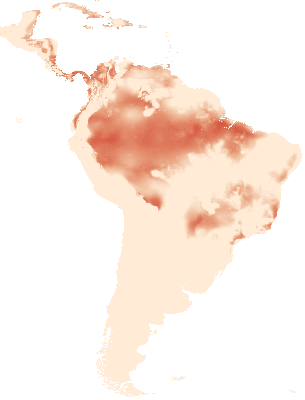

In [24]:
rendered_raster = arcpy.ia.Render(out_raster, rendering_rule = {"min": -1, "max": 1}, colormap = "Errors")
rendered_raster.exportImage(height = 400)

## Cited
1. Phillips, S.J., et al. 2006. Maximum entropy modeling of species geographic distributions.Ecological Modelling.190:231-259